# Projeto 1 - Ciência dos Dados

Nome: Enzo Luidge

Nome: Thiago Teixeira

Atenção: Serão permitidos grupos de três pessoas, mas com uma rubrica mais exigente. Grupos deste tamanho precisarão fazer um questionário de avaliação de trabalho em equipe

___
Carregando algumas bibliotecas:

In [18]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [19]:
print('Esperamos trabalhar no diretório')
print(os.getcwd())

Esperamos trabalhar no diretório
C:\Users\tynam\OneDrive\Documentos\Cdados\projeto 1


Carregando a base de dados com os tweets classificados como relevantes e não relevantes:

In [20]:
filename = 'Calamidade.xlsx'

In [21]:
train = pd.read_excel(filename)
train.head(5)

,Treinamento,Relevancia
0,não vai ter reprise hojeeeeeeeeee??? #calamidade,0
1,"agatha tá de novo visu, mas a linguinha já é m...",0
2,"o chat tá dizendo que vai ter, então vai ter n...",0
3,tive q fazer akkzkskkskak \ncarina conhecendo ...,0
4,a abertura de calamidade ta tao tao tao tao fo...,1


In [22]:
test = pd.read_excel(filename, sheet_name = 'Teste')
test.head(5)

,Teste,Relevancia
0,#calamidade kkkkkkkkkkkkkkkkkkkkk carina mafio...,0
1,"reassistindo o episódio, anotando várias coisa...",0
2,spoilerzinha da minha oc de ordem paranormal 🤭...,0
3,avisa que são eles!!! #calamidadefanart #calam...,0
4,sobre #calamidade ninguém tá se perguntando qu...,0


___
## Classificador automático de sentimento


Nosso produto é a série de RPG Ordem Paranormal: Calamidade, que acontece aos sábados na Twitch, no canal Cellbit. Como essa temporada começou recentemente, atingindo mais de 120 mil espectadores ao vivo logo no primeiro episódio, achamos se tratar de um produto interessante para a classificação de tweets.

Classificação: nossa classificação foi feita considerando como "relevante" tweets que continham opiniões, reclamações e apontamentos sobre a série, classificando como "irrelevante" todo o resto.

___
### Montando um Classificador Naive-Bayes

Considerando apenas as mensagens da planilha Treinamento, ensine  seu classificador.

In [23]:
! pip install emoji
import emoji  #importando a biblioteca emoji para tratar os emojis dos tweets

In [24]:
def cleanup(text):
    
    text = emoji.demojize(text, delimiters=(' ',' ')) #ttransforma os emojis em palavras, sendo possível tratá-los
    text_subbed = "".join(u for u in text if u not in ("?", ".", ";", ":", "!",'"',"'","-","\n","#","(",")","[","]",","))
    stopwords = ['a','que','o','e','se','da','em','com', 'do','q', 'de','pra'] #para a limpeza das stopwords mais comuns
    
    text_subbed = text_subbed.split() #separa todas as palavras em uma lista
    
    text_list = []
    for i in text_subbed: 
        if not ('https' in i) and not ('@' in i) and not (i in stopwords): #exclui links, nomes de perfis e stopwords
            text_list.append(i)
    
    text_final = ' '.join(text_list) #junta as palavras separando por espaço, corrigindo espaços duplos
    return text_final.lower()

string = 'Hello World! I LOVE #CALAMIDADE,   HAHAHAHA\n YES 🤐🤐🤐'

print(cleanup(string))

hello world i love calamidade hahahaha yes zippermouth_face zippermouth_face zippermouth_face


In [25]:
#Conjunto de todas as palavras:
todas_palavras = ' '.join(train.Treinamento)
todas_palavras = cleanup(todas_palavras)
todas_palavras = todas_palavras.split()
serie_todas_palavras = pd.Series(todas_palavras)
tabela_todas_palavras = serie_todas_palavras.value_counts() #Sem normalizar os valores, para a suavização Laplace depois

#Conjunto de palavras dos Tweets relevantes:
relevantes = ' '.join(train.Treinamento[train.Relevancia==1])
relevantes = cleanup(relevantes)
relevantes = relevantes.split()
serie_relevantes = pd.Series(relevantes)
tabela_relevantes = serie_relevantes.value_counts()

#Conjunto de palavras dos Tweets irrelevantes:
irrelevantes = ' '.join(train.Treinamento[train.Relevancia==0])
irrelevantes = cleanup(irrelevantes)
irrelevantes = irrelevantes.split()
serie_irrelevantes = pd.Series(irrelevantes)
tabela_irrelevantes = serie_irrelevantes.value_counts()

***R***: Relevantes

***I***: Irrelevantes

In [26]:
probR = len(relevantes)/len(todas_palavras)
probI = len(irrelevantes)/len(todas_palavras)

In [27]:
def classificador(Tweet): #Função do classificador
    Tweet = cleanup(Tweet)
    
    probTweetDadoR = 1
    probTweetDadoI = 1

    for palavra in Tweet.split(): #Com suavização Laplace
        if palavra in relevantes:
            probTweetDadoR = probTweetDadoR*((tabela_relevantes[palavra]+1)/(len(tabela_relevantes)+len(tabela_todas_palavras)))
        else:
            probTweetDadoR = probTweetDadoR*(1/len(tabela_todas_palavras))


        if palavra in irrelevantes:
            probTweetDadoI = probTweetDadoI*((tabela_irrelevantes[palavra]+1)/(len(tabela_irrelevantes)+len(tabela_todas_palavras)))
        else:
            probTweetDadoI = probTweetDadoI*(1/len(tabela_todas_palavras))
            
    probRdadoTweet = probTweetDadoR*probR
    probIdadoTweet = probTweetDadoI*probI

    if probRdadoTweet > probIdadoTweet:
        return 1 #Relevante
    else:
        return 0 #Irrelevante

___
### Verificando a performance do Classificador

Agora você deve testar o seu classificador com a base de Testes.

In [28]:
for tweet in test.Teste:
    if classificador(tweet) == 1:
        test.loc[test.Teste==tweet,'Classificador'] = 1
    else:
        test.loc[test.Teste==tweet,'Classificador'] = 0
    
v_positivos = (len(test.loc[(test.Classificador==1)&(test.Relevancia==1),:])/len(test))
v_negativos = (len(test.loc[(test.Classificador==0)&(test.Relevancia==0),:])/len(test))
f_positivos = (len(test.loc[(test.Classificador==1)&(test.Relevancia==0),:])/len(test))
f_negativos = (len(test.loc[(test.Classificador==0)&(test.Relevancia==1),:])/len(test))

print('Verdadeiros positivos: {0}%'.format(v_positivos*100))
print('Verdadeiros negativos: {0}%'.format(v_negativos*100))
print('Falsos positivos: {0}%'.format(f_positivos*100))
print('Falsos negativos: {0}%'.format(f_negativos*100))

print('Acurácia: {0}%'.format((v_positivos+v_negativos)*100))

Verdadeiros positivos: 12.5%
Verdadeiros negativos: 63.0%
Falsos positivos: 19.5%
Falsos negativos: 5.0%
Acurácia: 75.5%


Com uma acurácia de 75,5%, o classificador se mostra eficaz em filtrar os tweets para esta disposição entre tweets base e treinamento.

___
### Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste

Caso for fazer esse item do Projeto

In [29]:
#Juntando os dois dataframes:
dados = train.append(test).reset_index()
Tweets = []
for tweet in train.Treinamento:
    Tweets.append(tweet)
    
for tweet in test.Teste:
    Tweets.append(tweet)

dados['Tweets'] = Tweets 
dados = dados.drop(['index','Classificador','Treinamento','Teste'], axis=1)

In [30]:
#Repetindo os items 3 a 4 para cada nova separação:
acertos = []
for i in range(100):
    test = dados.sample(frac = 4/6)
    train = dados.drop(test.index)

    #Conjunto de todas as palavras:
    todas_palavras = ' '.join(train.Tweets)
    todas_palavras = cleanup(todas_palavras)
    todas_palavras = todas_palavras.split()
    serie_todas_palavras = pd.Series(todas_palavras)
    tabela_todas_palavras = serie_todas_palavras.value_counts() #Sem normalizar os valores, para a suavização Laplace depois

    #Conjunto de palavras dos Tweets relevantes:
    relevantes = ' '.join(train.Tweets[train.Relevancia==1])
    relevantes = cleanup(relevantes)
    relevantes = relevantes.split()
    serie_relevantes = pd.Series(relevantes)
    tabela_relevantes = serie_relevantes.value_counts()

    #Conjunto de palavras dos Tweets irrelevantes:
    irrelevantes = ' '.join(train.Tweets[train.Relevancia==0])
    irrelevantes = cleanup(irrelevantes)
    irrelevantes = irrelevantes.split()
    serie_irrelevantes = pd.Series(irrelevantes)
    tabela_irrelevantes = serie_irrelevantes.value_counts()


    for tweet in test.Tweets:
        if classificador(tweet) == 1:
            test.loc[test.Tweets==tweet,'Classificador'] = 1
        else:
            test.loc[test.Tweets==tweet,'Classificador'] = 0

    v_positivos = (len(test.loc[(test.Classificador==1)&(test.Relevancia==1),:])/len(test))
    v_negativos = (len(test.loc[(test.Classificador==0)&(test.Relevancia==0),:])/len(test))
    acerto = v_positivos + v_negativos

    acertos.append(acerto)

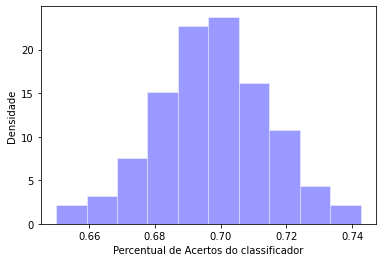

In [32]:
plt.hist(acertos, color='blue', edgecolor='white', alpha = 0.4, density=True)
plt.xlabel('Percentual de Acertos do classificador')
plt.ylabel('Densidade')
plt.show()

In [36]:
serie_acertos = pd.Series(acertos)
serie_acertos.describe().to_frame()

,0
count,100.000000
mean,0.697500
std,0.017317
min,0.650000
25%,0.685000
50%,0.697500
75%,0.708125
max,0.742500


Dependendo da distibuição dos mesmos tweets entre a base de treinamento e a base de teste, o percentual de acerto do classificador flutua  em torno de um valor médio. Ao se usar apenas uma distribuição, essa flutuação de percentual é um obstáculo para avaliar a competência do classificador.

___
### Descrição do projeto e conclusão

***Introdução***

Um classificador Naive-Bayes é um algoritmo que é capaz de classificar informações em diferentes categorias baseada nas probabilidades dos parâmetros individuais de cada informação. Esse algoritmo tem aplicações famosas em classificações de palavras ou frases (admitindo-se que as palavras ocorrem de maneira independente na frase), mas suas aplicações podem abrangir outras áreas, como até a categorização de falhas ocorridas em robôs manipuladores (WANKE, 2014).

Este projeto visou criar um classificador Naive-Bayes para classificar tweets relacionados à série de RPG Ordem Paranormal: Calamidade, que ocorre na plataforma Twitch aos sábados. A classificação foi feita considerando como "relevante" tweets que contêm opiniões, reclamações e apontamentos sobre a série, e "irrelevante" para todo o restante.

***Construção do classificador***

Para iniciar a construção do classificador, foi adquirida uma base de dados com 600 tweets manualmente classificados, dividindo-a em uma planilha para o treinamento do classificador, com 400 tweets, e uma planilha para os testes de performance, contendo 200 tweets. Para facilitar o tratamento de dados, foi construída uma função para limpar os tweets, transformando emojis em palavras, deixando todas as letras em minúsculo, retirando sinais de pontuação, excluindo nomes de perfil, retirando links, desconsiderando stopwords etc.

Com os tweets limpos e considerando apenas os da base de treinamento, foram adquiridos três conjuntos de palavras: o conjunto contendo todas as palavras, o conjunto de todas as palavras apenas dos tweets manualmente classificados como relevantes e o conjunto de palavras dos tweets classificados como irrelevantes. Utilizando esses três conjuntos, foi possível adquirir a probabilidade de uma palavra ser relevante e a probabilidade de uma palavra ser irrelevante.

O próximo passo foi, então, fazer uma função para o classificador onde, para cada tweet, seria analisada o quão relevante e irrelevante cada palavra do tweet seria com base na sua frequência relativa no conjunto de palavras relevantes e irrelevantes, respectivamente, multiplicando essas probabilidades entre si para se obter a probabilidade de a frase aparecer entre os relevantes ou irrelevantes (admitindo-se independência entre as palavras). Para evitar zerar a probabilidade total do tweet no caso de uma palavra inédita, foi utilizada uma suavização Laplace em cada probabilidade relativa. 

Como última etapa do classificador, foi multiplicada a probabilidade da frase aparecer entre os relevantes com a probabilidade geral de uma palavra ser relevante e o mesmo processo para os irrelevantes, resultando na probabilidade do tweet ser relevante e na probabilidade do tweet ser irrelevante. São comparadas ambas as duas probabilidades e, dependendo de qual a maior, o classificador classifica o tweet como relevantes ou irrelevante.


***Resultados***

Testando, então, o classificador na base de testes, pode-se perceber uma acurácia (soma da porcentagem de verdadeiros positivos com verdadeiros negativos) de 75,5% para os tweets analisados para a distribuição utilizada. Porém, como a distribuição de tweets entre base de testes e treinamento pode impactar na acurácia do classificador, foram testadas 100 combinações diferentes de tweets com as mesmas proporções iniciais entre treinamento e base, salvando a acurácia de cada distribuição em uma lista. Analisando os resultados, o acerto em média do classificador foi de 69,75%, para as 100 distribuições.

***Conclusões***

Considerando que o classificador em média tem uma performance razoavelmente boa (próxima de 70%), pode-se afirmar que o categorizador poderia ser uma ferramenta útil para a filtragem de tweets com opiniões sobre a série, especialmente considerando o quão raro pode ser encontrar um tweet relevante em meio a muitos irrelevantes.

Para melhorar sua performance, uma possível medida a ser tomada seria de adquirir mais tweets manualmente classificados para a base de treinamento, aumentando o repertório do algoritmo para calcular as probabilidades. Uma ideia que pederia surgir para facilitar esse processo de aprimoração do projeto seria de deixar o próprio programa classificar os tweets adicionais, mas essa *NÃO* seria uma ideia válida para aprimorar sua performance, uma vez que o classificador apenas iria se alimentar com os próprios erros, ao invés de adquirir mais parâmetros para os cálculos das probabilidades. 

___
## Aperfeiçoamento:

Trabalhos que conseguirem pelo menos conceito B vão evoluir em conceito dependendo da quantidade de itens avançados:

* IMPLEMENTOU outras limpezas e transformações que não afetem a qualidade da informação contida nos tweets. Ex: stemming, lemmatization, stopwords
* CORRIGIU separação de espaços entre palavras e emojis ou entre emojis e emojis
* CRIOU categorias intermediárias de relevância baseadas na probabilidade: ex.: muito relevante, relevante, neutro, irrelevante, muito irrelevante. Pelo menos quatro categorias, com adição de mais tweets na base, conforme enunciado. (OBRIGATÓRIO PARA TRIOS, sem contar como item avançado)
* EXPLICOU porquê não pode usar o próprio classificador para gerar mais amostras de treinamento
* PROPÔS diferentes cenários para Naïve Bayes fora do contexto do projeto
* SUGERIU e EXPLICOU melhorias reais com indicações concretas de como implementar (indicar como fazer e indicar material de pesquisa)
* FEZ o item 6. Qualidade do Classificador a partir de novas separações dos tweets entre Treinamento e Teste descrito no enunciado do projeto (OBRIGATÓRIO para conceitos A ou A+)

___
## Referências

[Naive Bayes and Text Classification](https://arxiv.org/pdf/1410.5329.pdf)  **Mais completo**

[A practical explanation of a Naive Bayes Classifier](https://monkeylearn.com/blog/practical-explanation-naive-bayes-classifier/) **Mais simples**

WANKE, Bruna dos Santos Lazéra et al. APLICAÇÃO DO CLASSIFICADOR NAIVE BAYES PARA IDENTIFICAÇÃO DE FALHAS DE UM MANIPULADOR ROBÓTICO. 2014.